In [41]:
import pandas as pd
import numpy as np

# Initial Cleaning

#### Loading Clean DF

In [42]:
data = pd.DataFrame(pd.read_excel('CLEAN DATA FOR PANDAS MANIPULATION.xlsx'))
for_clustering = data.copy()

#### Checking for Null Values and Duplicates

In [43]:
print(f"Total Null {for_clustering.isnull().sum().sum()}")
for_clustering.isnull().sum().reset_index().rename(columns = {'index':'Column_Names', 0:'Null Count'})


Total Null 385


,Column_Names,Null Count
0,Age,0
1,Gender,0
2,Race,0
3,Nationality,0
4,Employment status,0
...,...,...
108,Donations,0
109,Mentoring,0
110,Befriending,0
111,I currently assume a leadership role in my com...,0


In [44]:
print(f'Number of Duplicates: {for_clustering.duplicated().sum()}')

Number of Duplicates: 0


#### Removing unnecessary columns

These columns are those that have a lot of null values, subjective, and consolidations.

In [45]:
for_clustering = for_clustering.drop([
                    'Complete the sentence: "I become a senior when ______________."', 
                    'Seniorhood starts at ____ years old.',
                    'Spouse / Partner', 
                    'Are there other significant events that happened to you within the past 2 years that happened? List them down. (Indicate N.A. if not applicable)',
                    'Unnamed: 21', 
                    'Unnamed: 35', 
                    'Unnamed: 47', 
                    'Unnamed: 82', 
                    'Unnamed: 105', 
                    'Unnamed: 112'], axis=1)

In [46]:
print(f"Pruned Data Shape : {for_clustering.shape}")

Pruned Data Shape : (304, 103)


#### Identifying Ordinal Data

In [47]:
#These columns contain data with answers ranging from Strongly Disagree to Strongly Agree (will remain as int)
degree_columns = [
'To what extent do you agree with this statement: I am confident I have enough money to live the lifestyle I want / to provide for myself at this point.',
'I am managing my health issues well so I can stay active.',
'I am worried for my mental health. (e.g. dementia / depression)',
'"I don\'t want to retire, I want to keep on working."',
'"Working gives me a sense of purpose that I cannot find anywhere else"',
'"I am carefree and prefer not to think so much. I just want to relax and live out my years."',
'"I spend most of my time participating in activities with people in the community."',
'"I pamper myself, live life to the fullest and do things I enjoy."',
'"I actively help others and involve myself in the community. I want to continue giving to society."',
'I am proud to call myself a senior.',
'I am comfortable with being called a senior.',
'I feel valued as a senior in society.',
'I feel like society has a negative stereotype of seniors.',
'It is difficult for me to find activities to spend time meaningfully.',
'Because of my health, there are many activities I think I cannot do anymore.',
'I am / was fully-prepared for retirement.',
'If you are retired, answer this question: Retirement is what I expected it to be.',
'I think it is important for me to keep growing in life.',
'I am constantly challenging myself to achieve my goals.',
'It is easy and comfortable for me to talk to people in the community.',
'I often feel lonely.',
'I know of activities in the neighbourhood that I can take part in.',
'I feel a sense of belonging and ownership of spaces in my community. (e.g. community centres, parks, fitness corners, void decks)',
'I am confident to use technology to connect with people around me.',
'It is important for me to be involved in the community.',
'I am satisfied with my current level of involvement in the community.',
]
print(len(degree_columns))

26


In [48]:
_ = for_clustering[degree_columns] #error check

In [49]:
keywords = ['often', 'many']
ordinal_data_columns_df = for_clustering.loc[:, ~for_clustering.columns.isin(degree_columns)]

#Data that will remain as an int data type
often_many_columns = ordinal_data_columns_df.columns[ordinal_data_columns_df.columns.str.contains('|'.join(keywords))] 



In [50]:
often_many_columns = list(often_many_columns)

In [51]:
often_many_columns.extend(['Monthly household income from work (total amount of salary income by everyone in your household)', 'Total number of people living in your household including yourself'])

In [52]:
_ = for_clustering[often_many_columns] #error check

#### Identifying Categorical Data
After grouping ordinal data, it would make sense to think that the remaining columns all contain categorical data.

In [53]:
categorical_data = for_clustering.columns[~for_clustering.columns.isin(list(often_many_columns)+degree_columns)]
categorical_data = categorical_data.drop('Age')

In [54]:
_ = for_clustering[categorical_data] #error Check
len(categorical_data)

58

CHECK IF GROUPED COLUMNS = FOR CLUSTERING COLUMNS

In [55]:
print(f"Total Columns Clean: {categorical_data.shape[0]+len(degree_columns)+len(often_many_columns)+1}") #+1 here is age
print(f"Total Original DF Columns: {for_clustering.shape[1]}")

Total Columns Clean: 103
Total Original DF Columns: 103


# Conversion of Nominal Data to string for Amazon DenseClus

In [56]:
hdbscan_data = for_clustering.copy()

In [57]:
hdbscan_data.shape

(304, 103)

In [58]:
hdbscan_data[categorical_data] = hdbscan_data[categorical_data].applymap(lambda x: str(x))

In [59]:
hdbscan_data.dtypes

Age                                                                                                                                         int64
Gender                                                                                                                                     object
Race                                                                                                                                       object
Nationality                                                                                                                                object
Employment status                                                                                                                          object
                                                                                                                                            ...  
Working                                                                                                                     

# HDBSCAN using DenseClus

In [60]:
from denseclus import DenseClus
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\ACER\anaconda3\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


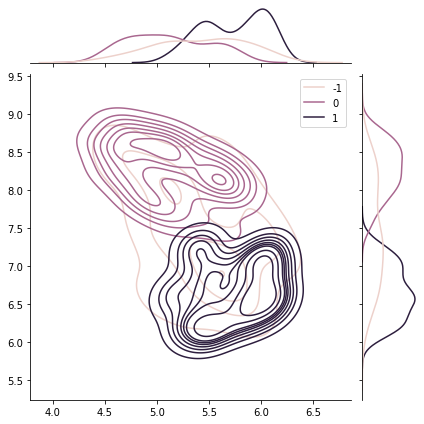

In [61]:


dclus = DenseClus(
    min_cluster_size=80,
    random_state=69,
    cluster_selection_method="leaf",
)

dclus.fit(hdbscan_data)

labels = dclus.score()
sns.jointplot(
    x=dclus.mapper_.embedding_[:, 0],
    y=dclus.mapper_.embedding_[:, 1],
    hue=labels,
    kind="kde")
plt.show()
    

# Setting Up DataFrame with Labels

In [79]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [62]:
labelled = hdbscan_data.copy()
median_labelled = hdbscan_data.copy()
mean_labelled = hdbscan_data.copy()

In [63]:
labelled['labels'] = labels #main df

In [80]:
median_labelled["segment"] = dclus.score()

numerics = median_labelled.select_dtypes(include=[int, float]).drop(["segment"], 1).columns.tolist()

median_labelled = median_labelled[numerics + ["segment"]].groupby(["segment"]).median()

# Random Forest Feature Selection

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [83]:
train = labelled.drop(columns='labels')
test = labelled['labels']
X_train, X_test, y_train, y_test=train_test_split(train,test ,test_size=0.30,random_state=69)


In [85]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

Top 10 Most Important Columns

Text(0.5, 1.0, 'Feature Importance Ranking')

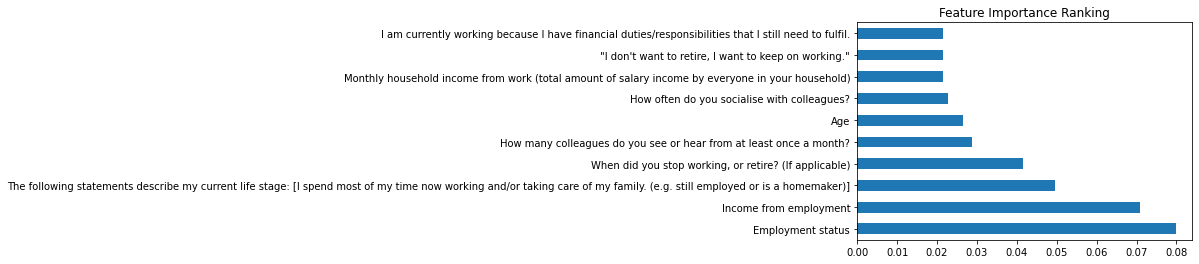

In [86]:
feature_importances=rf.feature_importances_
feature_importances_df=pd.DataFrame({'Variable':list(X_train), 'Variable importance':feature_importances})

feature_importances_df.sort_values('Variable importance',ascending=False)

feat_importances = pd.Series(rf.feature_importances_, index=train.columns)

feat_importances.nlargest(10).plot(kind='barh')
plt.title("Feature Importance Ranking")

In [105]:
importance_df = feature_importances_df.sort_values(by='Variable importance',ascending=False) #for excel save

labelled = dataframe with cluster labels

importance_df = dataframe that shows the importance of each column

median_labelled = median comparison for each cluster

mean_labelled = mean comparison for each clsuter